The file is for predicting failure type. The failure type column of the dataset is used. The model is a Support Vector Machine based classifier SVC which uses one-vs-rest approach for multi-class classification.

# Importing Libraries and Dataset

In [1]:
# importing libraries
import numpy as np
import pandas as pd
from numpy import unique, mean, std
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import jaccard_score
import warnings
warnings.simplefilter('ignore')
sns.set_theme(style="dark")

In [2]:
# importing dataset from github
url = "https://raw.githubusercontent.com/MHBaloch/Machine-Learning-/main/Data.csv" # importing url
dataset = pd.read_csv(url) # reading data fro url
data = dataset # creating dataframe
data.head(2)

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure


# Data Pre-processing

## Feature Engineering

In [3]:
# creating new columns based on the input variables and described in data description
data['Power'] = data['Rotational speed [rpm]']*data['Torque [Nm]'] # power column based on two input variables
data['Overstrain'] = data['Tool wear [min]']*data['Torque [Nm]'] # overstrain column based on two input variables
data['Temperature'] = data['Process temperature [K]']-data['Air temperature [K]'] # Temp column based on two input variables
data.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type,Power,Overstrain,Temperature
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure,66382.8,0.0,10.5
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure,65190.4,138.9,10.5
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure,74001.2,247.0,10.4
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure,56603.5,276.5,10.4
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure,56320.0,360.0,10.5


## Data Cleaning

In [4]:
# droping nominal numerical features
df = data.drop(['UDI','Product ID'], axis = 1)
df.head(2)

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type,Power,Overstrain,Temperature
0,M,298.1,308.6,1551,42.8,0,0,No Failure,66382.8,0.0,10.5
1,L,298.2,308.7,1408,46.3,3,0,No Failure,65190.4,138.9,10.5


In [5]:
# total count of failures except No Failure
df_f_type = df[df['Failure Type'].isin(['Power Failure', 'Overstrain Failure', 'Heat Dissipation Failure', 'Tool Wear Failure', 'Random Failures'])]
len(df_f_type) # returns the total failures except no failure

348

In [6]:
# dropping wrong/ambiguous values
df_failure = df[df['Target']>=1] # samples where target is 1
df_f_true = df_failure[df_failure['Failure Type']!='No Failure'] # samples where target is 1 but failure type is no failutre
df_no_f_true = df[(df['Failure Type']=='No Failure') & (df['Target']<=0)] # true no failure columns
df_true = pd.concat([df_f_true,df_no_f_true]).reset_index(drop=True) # true insatnces without ambiguity
data.shape ,df_true.shape

((10000, 13), (9973, 11))

## Data Transformation

In [7]:
# labeling categorical column 'Failure Type' with numerical values.
df_ = df_true.copy() # creating a copy of original df
encoder = LabelEncoder() # defining encoder
df_['Failure Type'] = encoder.fit_transform(df_['Failure Type']) # encoding the class labels
print(encoder.classes_)# printing encoded label classes as per the encoding scheme starting from 0
df_.head()
# source (https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html)

['Heat Dissipation Failure' 'No Failure' 'Overstrain Failure'
 'Power Failure' 'Tool Wear Failure']


,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type,Power,Overstrain,Temperature
0,L,298.9,309.1,2861,4.6,143,1,3,13160.6,657.8,10.2
1,L,298.9,309.0,1410,65.7,191,1,3,92637.0,12548.7,10.1
2,L,298.8,308.9,1455,41.3,208,1,4,60091.5,8590.4,10.1
3,L,298.4,308.2,1282,60.7,216,1,2,77817.4,13111.2,9.8
4,L,298.3,308.1,1412,52.3,218,1,2,73847.6,11401.4,9.8


# Data Preparation for Multi-Class Classification

In [8]:
# train_test_split based on Target column and 80:20 ratio
X = df_.drop(columns=['Target', 'Failure Type', 'Type']) # defining X variable
y = df_['Failure Type'] # defining y variable
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.20, random_state=1, stratify=y) # train_test split
X_train.shape, y_train.shape, X_test.shape, y_test.shape # shape of the train and test subsets
# reason to drop type is that other failure types are not predicted right so it is to reduce dimensionality
# source (https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

((7978, 8), (7978,), (1995, 8), (1995,))

In [9]:
# creating validation subset
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=0) # train_test split for val
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape  # final count of all subsets
# source (https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

((6382, 8), (1596, 8), (1995, 8), (6382,), (1596,), (1995,))

## Feature Scaling

In [10]:
# normalizing continuous features
scaler = MinMaxScaler() # defining scaler
X_train = scaler.fit_transform(X_train) # scaler applied on train subset
X_val = scaler.fit_transform(X_val) # scaler applied on validation subset
X_test = scaler.fit_transform(X_test) # scaler applied on test subset
# source (https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)

# Imbalance Treatment

In [11]:
# getting class weights of failure type
class_weight = class_weight.compute_class_weight(class_weight = "balanced", classes = np.unique(y_train), y = y_train)
class_weight
# source (https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html)

array([17.72777778,  0.2069726 , 23.20727273, 20.58709677, 49.09230769])

In [12]:
# creating dictionary for class weights
class_weight = dict(zip(np.unique(y_train), class_weight))
class_weight
# source (https://stackoverflow.com/questions/69783897/compute-class-weight-function-issue-in-sklearn-library-when-used-in-keras-cl)

{0: 17.727777777777778,
 1: 0.20697259607588778,
 2: 23.207272727272727,
 3: 20.587096774193547,
 4: 49.09230769230769}

# Baseline Model

In [ ]:
# baseline model for comparison
dummy = DummyClassifier() # declaring classifier
dummy.fit(X_train, y_train) # fitting model
dummy.score(X_train, y_train) # score of model
# source (https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html)

# Model Building

In [14]:
# SVC with one-vs-rest approach and optimized is used as final model
final_model = SVC(kernel='rbf', C=10, gamma=0.1, class_weight=class_weight, random_state=0) 
# source (https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)

In [15]:
final_model.get_params # hyperparameters

<bound method BaseEstimator.get_params of SVC(C=10,
    class_weight={0: 17.727777777777778, 1: 0.20697259607588778,
                  2: 23.207272727272727, 3: 20.587096774193547,
                  4: 49.09230769230769},
    gamma=0.1, random_state=0)>

## Model Evaluation

In [ ]:
# 3 fold cross validation
score_train = cross_val_score(final_model, X_train, y_train, cv=3, scoring = 'f1_macro')
print('F1_macro: %.3f (%.3f)' % (mean(score_train), std(score_train))) # printing mean scores and mean standard deviation
# source (https://scikit-learn.org/stable/modules/cross_validation.html)

In [ ]:
# model validation
# classification report
#final_model.fit(X_train, y_train) # please remove '#' if intended to vaildate model
y_pred = final_model.predict(X_val) # declaring prediction variable
print(classification_report(y_val, y_pred)) # classification report based on validation subset
# source (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)

In [ ]:
# confusion matrix
c_matrix = confusion_matrix(y_val, y_pred, labels=final_model.classes_) # confusion matrix of validation subset
display = ConfusionMatrixDisplay(confusion_matrix=c_matrix, display_labels=final_model.classes_) # displaying c.matrix
display.plot()
plt.suptitle('Final Model') # used for title of the plot
plt.show()
# source (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)
# sourcs (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html)

# Model Validation 

In [16]:
# ultimate validation of the model on unseen test data
final_model.fit(X_train, y_train) # fitting model on train data
y_predict = final_model.predict(X_test) # declaring test prediction variable
print(classification_report(y_test, y_predict)) # classification report based on test subset
# source (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)

              precision    recall  f1-score   support

           0       0.27      1.00      0.42        22
           1       1.00      0.79      0.88      1929
           2       0.28      1.00      0.43        16
           3       0.37      0.89      0.52        19
           4       0.03      0.78      0.05         9

    accuracy                           0.80      1995
   macro avg       0.39      0.89      0.46      1995
weighted avg       0.98      0.80      0.87      1995



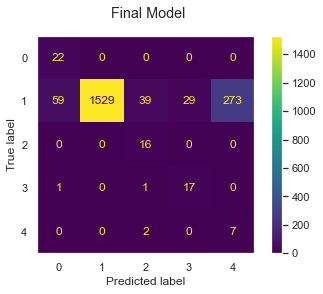

In [17]:
# confusion matrix for 
c_matrix = confusion_matrix(y_test, y_predict, labels=final_model.classes_) # confusion matrix of test subset
display = ConfusionMatrixDisplay(confusion_matrix=c_matrix, display_labels=final_model.classes_) # displaying c.matrix
display.plot()
plt.suptitle('Final Model') # used for title of the plot
plt.show()
# source (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)
# sourcs (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html)

In [24]:
jaccard_score(y_test, y_predict, average='macro')
# source (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.jaccard_score.html#sklearn.metrics.jaccard_score)

0.3431565572963962

All the actual failures Heat Dissipation Failure, Power Failure, Overstarain Failure and Tool Wear Failure are predicted accurately. However the no failure is incorrectly predicted around 20% of the total instances but its not as important as the actual failures.
While trying to improve recall, now 89% on macro average after improving, which is actually the true positivity rate and is essential as per the business problem i.e. predicting the failure, the precision dropped. The problem is about an imbalanced data therefore weighted scores are important. The accuracy and f1-score weighted average of the model are 80% and 87% respectively.